## Install required libraries using pip

In [2]:
!pip install gym
!pip install pygame
!pip install "gym[atari]"
!pip install opencv-python
!pip install torch torchvision
!pip install "stable-baselines3[extra]"
!pip install box2d-py

INFO: pip is looking at multiple versions of gym[atari] to determine which version is compatible with other requirements. This could take a while.
  Using cached gym-0.26.1.tar.gz (719 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.26.0.tar.gz (710 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.25.2.tar.gz (734 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.25.1.tar.gz (732 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached gym-0.25.0.tar.gz (720 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing met

## Imports

In [4]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from PIL import Image, ImageDraw, ImageFont
from collections import deque, namedtuple
from tqdm import trange
import pandas as pd

## List Of All Possible Environments From Gym

In [6]:
all_envs = sorted([env_id for env_id in gym.envs.registry.keys()])

for i, name in enumerate(all_envs[:50]):
    print(f"{i+1:2d}. {name}")

 1. Acrobot-v1
 2. Ant-v2
 3. Ant-v3
 4. Ant-v4
 5. Ant-v5
 6. BipedalWalker-v3
 7. BipedalWalkerHardcore-v3
 8. Blackjack-v1
 9. CarRacing-v3
10. CartPole-v0
11. CartPole-v1
12. CliffWalking-v0
13. FrozenLake-v1
14. FrozenLake8x8-v1
15. GymV21Environment-v0
16. GymV26Environment-v0
17. HalfCheetah-v2
18. HalfCheetah-v3
19. HalfCheetah-v4
20. HalfCheetah-v5
21. Hopper-v2
22. Hopper-v3
23. Hopper-v4
24. Hopper-v5
25. Humanoid-v2
26. Humanoid-v3
27. Humanoid-v4
28. Humanoid-v5
29. HumanoidStandup-v2
30. HumanoidStandup-v4
31. HumanoidStandup-v5
32. InvertedDoublePendulum-v2
33. InvertedDoublePendulum-v4
34. InvertedDoublePendulum-v5
35. InvertedPendulum-v2
36. InvertedPendulum-v4
37. InvertedPendulum-v5
38. LunarLander-v3
39. LunarLanderContinuous-v3
40. MountainCar-v0
41. MountainCarContinuous-v0
42. Pendulum-v1
43. Pusher-v2
44. Pusher-v4
45. Pusher-v5
46. Reacher-v2
47. Reacher-v4
48. Reacher-v5
49. Swimmer-v2
50. Swimmer-v3


In [7]:
# Create the environment
env = gym.make("LunarLander-v3")

# Reset environment to get initial observation
obs, info = env.reset()
print("Initial observation shape:", obs.shape)
print("Sample observation:", obs)

# Check action and observation space
print("\nObservation space:", env.observation_space)
print("Action space:", env.action_space)
print("Action space sample:", env.action_space.sample())

Initial observation shape: (8,)
Sample observation: [ 0.00674143  1.4075109   0.68281233 -0.15154341 -0.0078048  -0.15466738
  0.          0.        ]

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Action space sample: 3


In [8]:
# Create monitored training environment
#env = make_vec_env("LunarLander-v2", n_envs=1)

In [9]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
from collections import deque, namedtuple
from tqdm import trange

# Set up device (CPU or GPU)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## DQN

In [11]:
class DQNNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers=[128, 128]):
        super(DQNNetwork, self).__init__()
        layers = []

        prev_size = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev_size, h))
            layers.append(nn.ReLU())
            prev_size = h

        layers.append(nn.Linear(prev_size, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## Replay Buffer

In [13]:
class ReplayBuffer:
    def __init__(self, capacity, batch_size):
        self.memory = deque(maxlen=capacity)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience",
                                     field_names=["state", "action", "reward", "next_state", "done"])

    def __len__(self):
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        batch = random.sample(self.memory, k=self.batch_size)
        states = torch.tensor(np.vstack([e.state for e in batch]), dtype=torch.float32).to(device)
        actions = torch.tensor(np.vstack([e.action for e in batch]), dtype=torch.int64).to(device)
        rewards = torch.tensor(np.vstack([e.reward for e in batch]), dtype=torch.float32).to(device)
        next_states = torch.tensor(np.vstack([e.next_state for e in batch]), dtype=torch.float32).to(device)
        dones = torch.tensor(np.vstack([e.done for e in batch]).astype(np.uint8), dtype=torch.float32).to(device)

        return states, actions, rewards, next_states, dones

## DQN Agent Class

In [15]:
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size = 100000, batch_size=64,
                 gamma = 0.99, lr = 1e-3, tau = 1e-3, update_every = 4):

        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.update_every = update_every

        # Networks
        self.qnetwork_local = DQNNetwork(state_size, action_size).to(device)
        self.qnetwork_target = DQNNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size, batch_size)
        self.t_step = 0

    def act(self, state, eps=0.0):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            q_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if random.random() < eps:
            return random.choice(np.arange(self.action_size))
        else:
            return np.argmax(q_values.cpu().data.numpy())

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step = (self.t_step + 1) % self.update_every

        if self.t_step == 0 and len(self.memory) >= self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (self.gamma * q_targets_next * (1 - dones))
        q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = nn.MSELoss()(q_expected, q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update()

    def soft_update(self):
        for target_param, local_param in zip(self.qnetwork_target.parameters(),
                                              self.qnetwork_local.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

## DQN Training Loop

In [17]:
def train_dqn(env, agent, n_episodes = 1000, max_t = 1000,
              eps_start = 1.0, eps_end = 0.01, eps_decay = 0.995,
              target_score = 200.0, save_path = "dqn_lander.pth", verbose = True):
    
    scores = []  # All episode rewards
    scores_window = deque(maxlen = 100)  # Sliding window for average reward
    epsilon = eps_start  # Starting exploration rate

    bar = trange(n_episodes, desc = "Training", ascii = True)  # Progress bar
    for i_episode in bar:
        state, _ = env.reset()  # Reset environment
        total_reward = 0  # Episode reward counter

        for t in range(max_t):
            action = agent.act(state, eps = epsilon)  # Select action using ε-greedy
            next_state, reward, done, truncated, _ = env.step(action)  # Take step
            agent.step(state, action, reward, next_state, done)  # Store + learn
            state = next_state  # Move to next state
            total_reward += reward  # Update episode reward

            if done or truncated:  # Stop if episode ends
                break

        scores.append(total_reward)  # Store score
        scores_window.append(total_reward)  # Update moving average

        epsilon = max(eps_end, eps_decay * epsilon)  # Decay epsilon
        avg_score = np.mean(scores_window)  # Average of last 100 episodes

        # Show info in progress bar
        bar.set_postfix({
            "Epsilon": f"{epsilon:.3f}",
            "Score": f"{total_reward:.1f}",
            "Avg100": f"{avg_score:.1f}"
        })

        # Print every 100 episodes if enabled
        if verbose and (i_episode + 1) % 100 == 0:
            print(f"\nEpisode {i_episode + 1} | Average Score (last 100): {avg_score:.2f}")

        # Stop early if average score is good
        if avg_score >= target_score:
            print(f"\nEnvironment solved in {i_episode + 1} episodes! Avg score: {avg_score:.2f}")
            torch.save(agent.qnetwork_local.state_dict(), save_path)  # save model
            break

    # Save model at the end
    if avg_score < target_score:
        print(f"\n Training ended after {n_episodes} episodes. Best avg score: {avg_score:.2f}")
        torch.save(agent.qnetwork_local.state_dict(), save_path)

    return scores  # Return list of all episode rewards

## Training Model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the LunarLander-v3 environment
env = gym.make("LunarLander-v3")

# Get the number of input features (state size)
state_dim = env.observation_space.shape[0]

# Get the number of possible actions (action size)
action_dim = env.action_space.n

# Create the DQN agent using state and action dimensions
agent = DQNAgent(state_size = state_dim, action_size = action_dim)

# Train the agent and collect episode scores
scores = train_dqn(env, agent, n_episodes = 1000, target_score = 200)

Training:  11%|1| 106/1000 [00:02<00:26, 33.32it/s, Epsilon=0.588, Score=-251.6,


Episode 100 | Average Score (last 100): -146.92


Training:  20%|2| 202/1000 [00:07<00:49, 16.14it/s, Epsilon=0.361, Score=-51.2, 


Episode 200 | Average Score (last 100): -112.98


Training:  30%|3| 300/1000 [00:23<02:32,  4.59it/s, Epsilon=0.222, Score=6.4, Av


Episode 300 | Average Score (last 100): -67.62


Training:  40%|4| 400/1000 [00:43<01:59,  5.01it/s, Epsilon=0.135, Score=-49.7, 


Episode 400 | Average Score (last 100): -26.09


Training:  50%|5| 501/1000 [01:03<01:23,  5.97it/s, Epsilon=0.081, Score=193.1, 


Episode 500 | Average Score (last 100): 17.11


Training:  60%|6| 602/1000 [01:17<00:35, 11.16it/s, Epsilon=0.049, Score=258.1, 


Episode 600 | Average Score (last 100): 152.95


Training:  64%|6| 637/1000 [01:21<00:46,  7.83it/s, Epsilon=0.041, Score=280.4, 


Environment solved in 638 episodes! Avg score: 202.23


## Rewards versus Episodes

Plot saved to: results/dqn_training_performance.png


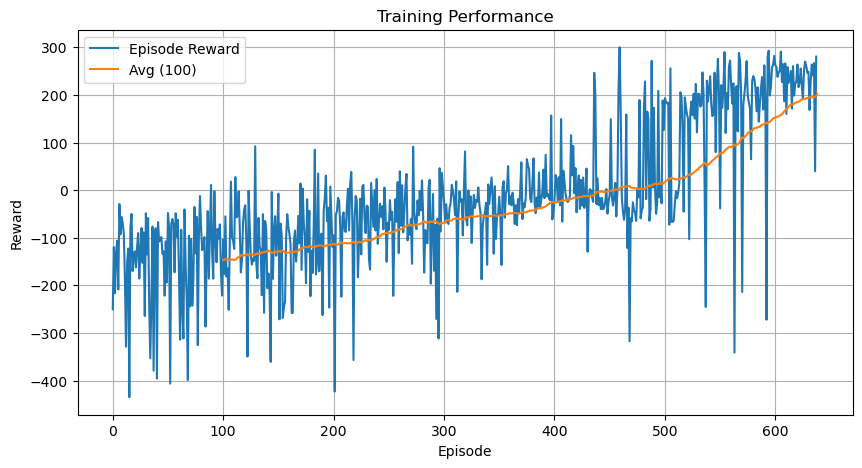

'results/dqn_training_performance.png'

In [21]:
def plot_and_save_scores_image(scores, folder = "results", filename = "dqn_training_performance.png"):
    os.makedirs(folder, exist_ok = True)

    image_path = os.path.join(folder, filename)

    plt.figure(figsize = (10, 5))
    plt.plot(scores, label = "Episode Reward")

    if len(scores) >= 100:
        avg100 = np.convolve(scores, np.ones(100) / 100, mode = 'valid')
        plt.plot(range(100, 100 + len(avg100)), avg100, label = "Avg (100)")

    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training Performance")
    plt.legend()
    plt.grid(True)

    plt.savefig(image_path, bbox_inches = "tight")
    print(f"Plot saved to: {image_path}")
    plt.show()

    return image_path

plot_and_save_scores_image(scores, folder = "results", filename = "dqn_training_performance.png")

## Test Training DQN Function

In [23]:
def test_dqn(env, agent, n_episodes = 5, max_t = 500, render = True):
    total_rewards = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        episode_reward = 0

        for t in range(max_t):
            if render:
                env.render()

            action = agent.act(state, eps = 0.0)
            next_state, reward, done, truncated, _ = env.step(action)
            episode_reward += reward
            state = next_state

            if done or truncated:
                break

        total_rewards.append(episode_reward)
        print(f"Episode {ep + 1} | Total Reward: {episode_reward:.2f}")

    env.close()
    avg_reward = np.mean(total_rewards)
    print(f"\n Average Reward over {n_episodes} episode(s): {avg_reward:.2f}")
    
    return total_rewards

def generate_results_table(reward_list):
    df = pd.DataFrame({
        "Episode": list(range(1, len(reward_list) + 1)),
        "Reward": reward_list
    })
    df.loc["Average"] = ["—", np.mean(reward_list)]
    return df

def save_results_csv(df, folder = "results", filename = "dqn_test_results.csv"):
    os.makedirs(folder, exist_ok = True)
    file_path = os.path.join(folder, filename)
    df.to_csv(file_path, index = False)
    print(f"Results saved to: {file_path}")

In [24]:
agent.qnetwork_local.load_state_dict(torch.load("dqn_lander.pth"))

env = gym.make("LunarLander-v3", render_mode = "human")

rewards = test_dqn(env, agent, n_episodes = 3)

df_results = generate_results_table(rewards)
save_results_csv(df_results, folder = "results", filename = "dqn_test_results.csv")

df_results

2025-04-28 08:42:13.115 python[69257:5029525] +[IMKClient subclass]: chose IMKClient_Modern
2025-04-28 08:42:13.115 python[69257:5029525] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Episode 1 | Total Reward: 60.25
Episode 2 | Total Reward: 222.43
Episode 3 | Total Reward: 74.35

 Average Reward over 3 episode(s): 119.01
Results saved to: results/dqn_test_results.csv


,Episode,Reward
0,1,60.249863
1,2,222.431689
2,3,74.346023
Average,—,119.009192


## GIF Recording

In [ ]:
## def record_dqn_gif(agent, env_id = "LunarLander-v3", filename = "dqn_demo.gif", folder = "results", max_steps = 500):
    os.makedirs(folder, exist_ok = True)
    env = gym.make(env_id, render_mode = "rgb_array")

    state, _ = env.reset()
    frames = []
    total_reward = 0

    for _ in range(max_steps):
        frame = env.render()
        img = Image.fromarray(frame)
        draw = ImageDraw.Draw(img)
        try:
            font = ImageFont.truetype("arial.ttf", 16)
        except:
            font = ImageFont.load_default()
        
        draw.text((10, 10), f"Score: {total_reward:.2f}", font = font, fill = (255, 255, 255))
        frames.append(np.array(img))
        action = agent.act(state, eps = 0.0)
        state, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        if done or truncated:
            break

    env.close()

    gif_path = os.path.join(folder, filename)
    imageio.mimsave(gif_path, frames, fps = 30)
    print(f"GIF with overlay saved to: {gif_path}")

record_dqn_gif(agent, filename = "dqn_demo.gif", folder = "results")